### Matching CPS observations over time

##### Example with flow from disability to work

---

January 14, 2019

Brian Dew, @bd_econ

---

Example uses CPS microdata that has already been cleaned and saved as feather format files, to calculate what percent of people age 25 to 54 who were not working the year before due to disability but are employed in the current month. 

In [1]:
# Import packages and set preliminaries
import pandas as pd
import numpy as np
import os

os.chdir('/home/brian/Documents/CPS/')

In [2]:
# Calculate disabled to work flow
data = pd.DataFrame()

# For each year calculate change over year before
for year in list(range(1995, 2019)):

    # Load year one
    df1 = (pd.read_feather(f'data/clean/cps{year-1}.ft')
             .query('MIS < 5 and 23 <= AGE <= 57'))

    # Generate flow1 variable
    df1['flow1'] = np.where(df1['NILFREASON'] == 'Disabled/Ill', 1, 0)

    # Generate unique ID
    df1['UID'] = (df1['STATE'].astype(str) + 
                  df1['HHID'].astype(str) + 
                  df1['HHID2'].astype(str) + 
                  df1['PULINENO'].astype(str))

    # Filter column-wise
    df1 = df1[['UID','MONTH','YEAR','MIS','AGE','flow1', 'BASICWGT',
               'FEMALE','WBHAO','STATE']]

    # Load year two
    df2 = (pd.read_feather(f'data/clean/cps{year}.ft')
             .query('MIS > 4 and 23 <= AGE <= 57'))

    # Generate flow2 variable
    df2['flow2'] = np.where(df2['LFS'] == 'Employed', 1, 0)

    # Generate unique ID
    df2['UID'] = (df2['STATE'].astype(str) + 
                  df2['HHID'].astype(str) + 
                  df2['HHID2'].astype(str) + 
                  df2['PULINENO'].astype(str))

    # Filter column-wise
    df2 = df2[['UID','MONTH','YEAR','MIS','AGE','flow2', 'BASICWGT',
               'FEMALE','WBHAO','STATE']]

    # List of months to loop over 
    mos = list(range(1, max(df2['MONTH']) + 1))

    # Loop over the months
    for mo in mos:
        # Generate merge groups
        g1 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 1)]
        g5 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 5)]
        g2 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 2)]
        g6 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 6)]
        g3 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 3)]
        g7 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 7)]
        g4 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 4)]
        g8 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 8)]    

        # Naive merge
        naive = (pd.merge(g1, g5, on='UID', how='inner').append(
                 pd.merge(g2, g6, on='UID', how='inner')).append(
                 pd.merge(g3, g7, on='UID', how='inner')).append(
                 pd.merge(g4, g8, on='UID', how='inner')))    

        # Filter by SRA
        mdata = naive[(naive['FEMALE_x'] == naive['FEMALE_y']) &
                      (naive['WBHAO_x'] == naive['WBHAO_y']) &
                      ((naive['AGE_x'] <= naive['AGE_y'] + 1) |
                      (naive['AGE_y'] >= naive['AGE_x']))]   

        mdata = mdata[mdata['AGE_y'].between(25, 54)]
        
        # Calculate outflow
        of = mdata[(mdata['flow1']==1) & (mdata['flow2']==1)]['BASICWGT_y'].sum()

        # Calculate total
        tot = mdata[(mdata['flow1']==1)]['BASICWGT_y'].sum()

        # Print share
        data.at[pd.to_datetime(f'{year}-{mo}-01'), 'Share'] = (of/tot) * 100

/home/brian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in float_scalars


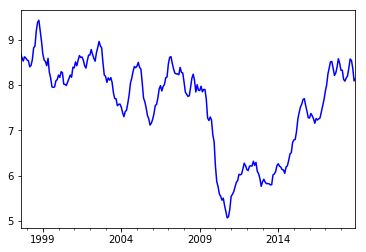

In [3]:
%matplotlib inline
data.rolling(12).mean().dropna().plot(color='blue', legend=None)